In [ ]:
import sys
sys.path.insert(0, '../src')

from megs.model.mPCA import mPCA
from megs.data import image, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

sns.set_context("paper")
#Load Data
data = DataLoader("/export/home/ucakir/MEGS/MEGS/src/megs/data/galaxy_data.hdf5")

norm = image.norm
lower = 0.25
upper = 1.0
norm_function_args = {"Masses": {"takelog": True, "plusone": True,"lower": lower, "upper": upper},
                     "GFM_Metallicity": {"takelog": True, "plusone": True, "lower": 0.1, "upper": upper},
                     "GFM_StellarFormationTime": {"takelog": True, "plusone": True, "lower": 0.1, "upper": upper},
                    
}

# Define Model
mm = mPCA(data, norm_function = norm, norm_function_kwargs=norm_function_args, dim = 2)

# Train Model
mm.fit(n_components=60, show_results = False)

File: /export/home/ucakir/MEGS/MEGS/src/megs/data/galaxy_data.hdf5
Group: Galaxies
    Group: Attributes
        Dataset: halo_id (float32) ((12484,))
        Dataset: mass (float32) ((12484,))
    Group: Particles
        Group: stars
            Group: Images
                Group: dim2
                    Dataset: GFM_Metallicity (float32) ((12484, 64, 64))
                    Dataset: GFM_StellarFormationTime (float32) ((12484, 64, 64))
                    Dataset: Masses (float32) ((12484, 64, 64))
                Group: dim3
                    Dataset: GFM_Metallicity (float32) ((12484, 64, 64, 64))
                    Dataset: GFM_StellarFormationTime (float32) ((12484, 64, 64, 64))
                    Dataset: Masses (float32) ((12484, 64, 64, 64))
Creating datamatrix with the following fields:
Particle type:  stars
Fields:  ['GFM_Metallicity', 'GFM_StellarFormationTime', 'Masses']
Dimension:  dim2
Default arguments are used for the fields that are not specified in the norm_fu

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import trange
torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


100%|██████████| 1000/1000 [09:14<00:00,  1.80it/s]


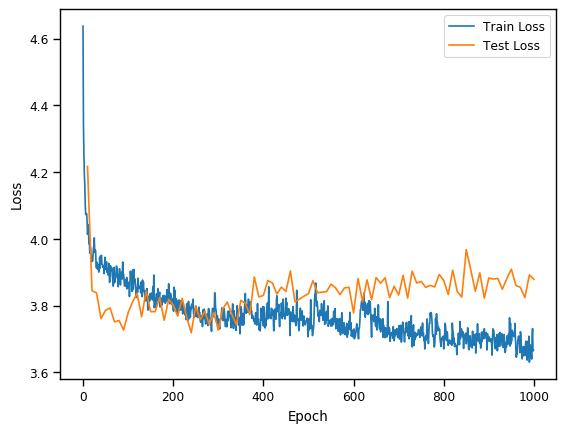

In [ ]:
# Define the neural network architecture
class Net(nn.Module):
    def __init__(self, layer_size_1, eigengalaxies):
        super(Net, self).__init__()
        num_eigengalaxies = eigengalaxies.shape[0]
        #Define the layers of your neural network
        self.fc1 = nn.Linear(layer_size_1, 512)
        self.fc2 = nn.Linear(num_eigengalaxies, 60)
        #self.fc3 = nn.Linear(256, 128)
        #self.fc4 = nn.Linear(128, 60)  # 60 output nodes for PCA scores
        self.dropout = nn.Dropout(0.5)  # Dropout layer for regularization
        self.eigengalaxies = torch.Tensor(eigengalaxies).to(device)

    def forward(self, x):
        #x = torch.flatten(x, start_dim=1)
        x = torch.matmul(x, self.eigengalaxies)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        return x


# Step 3: Split the dataset into training and testing sets

# Step 4: Train the neural network
img_size = 64 * 64
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = Net(layer_size_1=img_size).to(device)
criterion = nn.MSELoss().to(device)  # Use mean squared error as the loss function
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)  # Add weight decay for regularization

num_epochs = 1000

data = mm.datamatrix.reshape(12484, 3, 64, 64)
data = data[:, 0, :]  # Use only the first map to learn the scores
targets = mm.scores

# Split the data into train and test sets
train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.2, random_state=42)

# Assuming you have your training data and targets as tensors
train_data = torch.Tensor(train_data).to(device)
train_targets = torch.Tensor(train_targets).to(device)

test_data = torch.Tensor(test_data).to(device)
test_targets = torch.Tensor(test_targets).to(device)

# Convert test data and targets into a TensorDataset

# Convert training data and targets into a TensorDataset
train_dataset = TensorDataset(train_data, train_targets)
test_dataset = TensorDataset(test_data, test_targets)
# Define the batch size for training
batch_size = 64



# Create the train_loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

train_loss = []
test_loss = []

log_file = "loss_log.txt"

for epoch in trange(num_epochs):
    running_loss = 0.0
    for inputs, targets in train_loader:  # Iterate over the training set
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    average_loss = running_loss / len(train_loader)
    train_loss.append(average_loss)
    if epoch % 80 == 0:
        with open(log_file, "a") as f:
            f.write(f"Epoch {epoch+1}/{num_epochs}, Loss: {average_loss}\n")

        
     
    # Periodically compute and print the mean train and test loss
    if epoch % 10 == 0:
        test_loss_this_epoch = []

        # Set the model to evaluation mode
        model.eval()

        # Disable gradient calculation
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs = inputs.to(device)
                targets = targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                test_loss_this_epoch.append(loss.item())

        model.train()  # Set the model back to training mode

        test_loss_mean = torch.mean(torch.Tensor(test_loss_this_epoch)).item()
        test_loss.append(test_loss_mean)

        with open(log_file, "a") as f:
            f.write(f"Mean Test Loss: {test_loss[-1]:.2e}\n")

# Step 5: Evaluate the trained model
# Compute predicted PCA components for the testing set
# Compare predicted components with ground truth and calculate evaluation metrics

import matplotlib.pyplot as plt

plt.plot(range(len(train_loss)), train_loss, label='Train Loss')
plt.plot(range(10, num_epochs + 1, 10), test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Step 5: Evaluate the trained model
# Compute predicted PCA components for the testing set
